In [66]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [67]:
def circle_points_torch(radius, num_points):
    """
    Generate coordinates of points on the circumference of a circle using PyTorch.

    Parameters:
    radius (float): The radius of the circle.
    num_points (int): The number of points to generate on the circumference.

    Returns:
    torch.Tensor: A tensor of shape (num_points, 2) containing the coordinates of the points.
    """
    # Create a tensor of angles evenly spaced around the circle
    angles = torch.linspace(0, 2 * torch.pi, num_points)
    
    # Calculate the x and y coordinates for each point
    x = radius * torch.cos(angles)
    y = radius * torch.sin(angles)
    norm= torch.sqrt( x**2 + y**2 )
    n_x = x / norm
    n_y = y / norm
    points = torch.stack((x, y,n_x,n_y), dim=1)
    return points

def draw_p(l):
    for elem in l:
        plt.scatter(elem[0],elem[1],color="black")

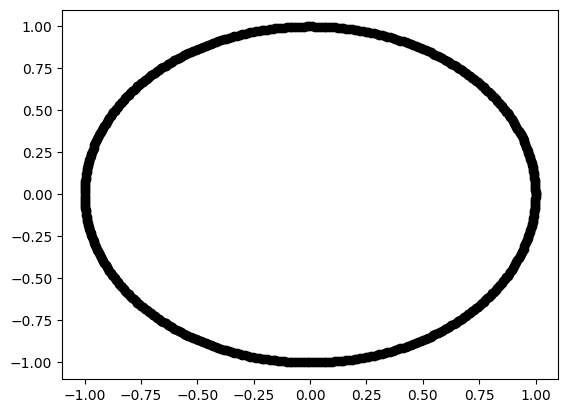

In [238]:
points_c=circle_points_torch(radius=1,num_points=500)
draw_p(points_c)

In [239]:
def get_borders(points):
    min_x=torch.min(points[:,0])
    max_x=torch.max(points[:,0])
    min_y=torch.min(points[:,1])
    max_y=torch.max(points[:,1])
    
    sep_x=torch.sqrt((max_x-min_x)**2)
    sep_y=torch.sqrt((max_y-min_y)**2)
    
    width=max(sep_x,sep_y)
    
    return (min_x,min_x+width,min_y,min_y+width)
    

def create_quadtree(dico,tmp_depth,depth,points,borders,label):
    min_x=borders[0]
    max_x=borders[1]
    min_y=borders[2]
    max_y=borders[3]
    
    sep_x=min_x+torch.sqrt((max_x-min_x)**2)/2.0
    sep_y=min_y+torch.sqrt((max_y-min_y)**2)/2.0
    
    
    
    
    mask=(points[:,0]<= sep_x) & (points[:,1]> sep_y)
    hg= points[mask]
    mask=(points[:,0]> sep_x) & (points[:,1]> sep_y)
    hd= points[mask]
    mask=(points[:,0]<= sep_x) & (points[:,1]<= sep_y)
    bg= points[mask]
    mask=(points[:,0]> sep_x) & (points[:,1]<= sep_y)
    bd= points[mask]
    
    
    gx=min_x
    gy=sep_y
    dx=sep_x
    dy=max_y
    
    tmp_oc=torch.zeros(2)
    tmp_oc[0]=(gx+dx)/2.0
    tmp_oc[1]=(gy+dy)/2.0
    border=(gx,dx,gy,dy)
    
    
    dico[label+"1"]=(tmp_depth,tmp_oc,dx-gx,border,hg)
    
    if (hg.shape[0]>1)and depth!=tmp_depth:
        create_quadtree(dico,tmp_depth+1,depth,hg.clone(),border,label+"1")
    
    gx=sep_x
    gy=sep_y
    dx=max_x
    dy=max_y
    
    tmp_oc=torch.zeros(2)
    tmp_oc[0]=(gx+dx)/2.0
    tmp_oc[1]=(gy+dy)/2.0
    border=(gx,dx,gy,dy)
    
    
    dico[label+"2"]=(tmp_depth,tmp_oc,dx-gx,border,hd)
    
    if (hd.shape[0]>1)and depth!=tmp_depth:
        create_quadtree(dico,tmp_depth+1,depth,hd.clone(),border,label+"2")
    
    gx=min_x
    gy=min_y
    dx=sep_x
    dy=sep_y
    
    tmp_oc=torch.zeros(2)
    tmp_oc[0]=(gx+dx)/2.0
    tmp_oc[1]=(gy+dy)/2.0
    border=(gx,dx,gy,dy)
    
    
    dico[label+"3"]=(tmp_depth,tmp_oc,dx-gx,border,bg)
    
    
    if (bg.shape[0]>1)and depth!=tmp_depth:
        create_quadtree(dico,tmp_depth+1,depth,bg.clone(),border,label+"3")
    
    gx=sep_x
    gy=min_y
    dx=max_x
    dy=sep_y
    
    tmp_oc=torch.zeros(2)
    tmp_oc[0]=(gx+dx)/2.0
    tmp_oc[1]=(gy+dy)/2.0
    border=(gx,dx,gy,dy)
    

    dico[label+"4"]=(tmp_depth,tmp_oc,dx-gx,border,bd)
    
    
    if (bd.shape[0]>1) and depth!=tmp_depth:
        create_quadtree(dico,tmp_depth+1,depth,bd.clone(),border,label+"4")
    
    
    
    
def draw_quadtree(dico):
    fig = plt.figure()
    
    for node in dico:
        depth,_,_,border,l_points=dico[node]
        gx,dx,gy,dy=border
        
        
        if depth==0:
            draw_p(l_points)
        
        plt.plot([gx,dx],[gy,gy],color="blue")
        plt.plot([gx,dx],[dy,dy],color="blue")
        plt.plot([gx,gx],[dy,gy],color="blue")
        plt.plot([dx,dx],[dy,gy],color="blue")
    
    
    

In [240]:
dico=dict()
bord=get_borders(points_c)
create_quadtree(dico,0,10,points_c,bord,"")

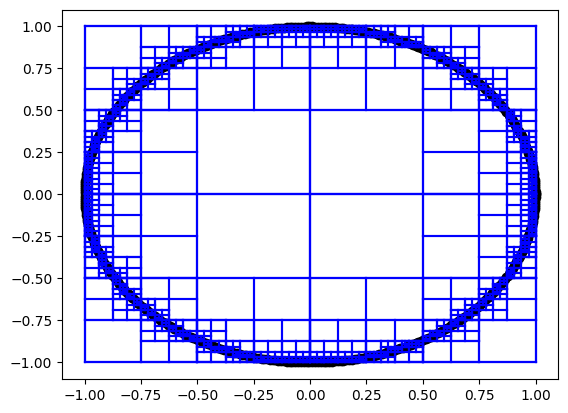

In [241]:
draw_quadtree(dico)

In [242]:
def get_min_width(dico,D):
    min_width=1e9
    for node in dico:
        if (dico[node][2]<min_width and dico[node][0]<=D ):
            min_width=dico[node][2]
    return min_width
        

s_p=points_c[:,:2]


#matrix s_p: (100,5)  o_s: (100,4,3)
#s_p:(100,5)  ->x,y,n_x,n_y,id_DICO
#o_s:(100,4,3)->x,y,w
def get_os(nb_s,dico,depth):
    cpt_p=0
    s_p=torch.ones((nb_s,5))
    o_s=torch.ones((nb_s,4,3))
    for node in dico:
        if dico[node][0]==D or (dico[node][0]<=D and len(dico[node][-1])==1):
            depth,o_c,o_w,border,l_points=dico[node]
            tmp_o_vec=torch.empty((4,3))
            for idx_nbgr in range(1,5):
                tmp_node=node[:-1]+str(idx_nbgr)
                tmp_o_vec[idx_nbgr-1,:2]=dico[tmp_node][1]
                tmp_o_vec[idx_nbgr-1,2]=dico[tmp_node][2]
                
                
            for p in l_points:
                s_p[cpt_p,:4]=p.clone()
                s_p[cpt_p,4]=np.uint(node)
                o_s[cpt_p]=tmp_o_vec.clone()
                cpt_p+=1
    return s_p,o_s
                
                
            
            
s_p,o_s=get_os(points_c.shape[0],dico,5)

#print(o_s.shape)

def get_alpha(s_p,o_s):
    #(100,4,2)
    tmp_mat_sp=torch.empty((o_s.shape[0],o_s.shape[1],o_s.shape[2]-1))
    tmp_mat_sp[:,0,:]=s_p[:,:2]
    tmp_mat_sp[:,1,:]=s_p[:,:2]
    tmp_mat_sp[:,2,:]=s_p[:,:2]
    tmp_mat_sp[:,3,:]=s_p[:,:2]

    #RMSE
    return torch.sum(torch.sqrt((tmp_mat_sp-o_s[:,:,:2])**2),dim=2)

def get_Fo(o_s,q):
    

    arg_f=tmp_mat_sp=torch.empty((o_s.shape[0],o_s.shape[1],o_s.shape[2]-1))
    tmp_mat_sp[:,0,:]=q.clone()
    tmp_mat_sp[:,1,:]=q.clone()
    tmp_mat_sp[:,2,:]=q.clone()
    tmp_mat_sp[:,3,:]=q.clone()
    
    w=o_s[:,:,2].view((o_s.shape[0],o_s.shape[1],1))
    
    
    tmp_mat_sp=(tmp_mat_sp-o_s[:,:,:2])/w
    
    tmp_mat_sp=torch.where(torch.abs(tmp_mat_sp)<0.5,1,0)
    
    tmp_mat_sp=torch.prod(tmp_mat_sp,dim=2)**3
    w=o_s[:,:,2].view((o_s.shape[0],o_s.shape[1]))
    
    return tmp_mat_sp*(1/w**3)  


def get_W(alpha,o_s,q):
    F_o=get_Fo(o_s,q[:2])
    
    return torch.sum(alpha*F_o)

def get_W_D(alpha,o_s,s_p):
    res=torch.empty(o_s.shape[0])
    for idx in range(o_s.shape[0]):
        res[idx]=get_W(alpha,o_s,s_p[idx][:2])
    return res

def get_alpha_final(s_p,o_s):
    #(100,4,2)
    tmp_mat_sp=torch.empty((o_s.shape[0],o_s.shape[1],o_s.shape[2]-1))
    tmp_mat_sp[:,0,:]=s_p[:,:2]
    tmp_mat_sp[:,1,:]=s_p[:,:2]
    tmp_mat_sp[:,2,:]=s_p[:,:2]
    tmp_mat_sp[:,3,:]=s_p[:,:2]

    #RMSE
    return torch.sum(torch.sqrt((tmp_mat_sp-o_s[:,:,:2])**2),dim=2)
    

In [243]:
alpha=get_alpha(s_p,o_s)

def get_average_density(s_p):
    res=torch.zeros(s_p.shape[0])
    
    for idx in range(s_p.shape[0]):
        tmp_p=s_p[idx,:2]
        F_o=get_Fo(o_s,tmp_p)
        
        
        res[idx]=torch.sum(alpha*F_o)
    
    return torch.mean(res)


def get_depth_sp(s_p,D,W_average):
    F_o=get_Fo(o_s,s_p)

    tmp_Wd=torch.sum(alpha*F_o)

    log_Wd=torch.log(tmp_Wd/W_average)/np.log(4)
    
  
    return np.rint(min(D,D+log_Wd))



In [315]:
#octree depth
D=7
#grid resolution
n_p=np.uint(1.0/get_min_width(dico,D))
#Average density for adaptative depth
W_average=get_average_density(s_p)
#image res
image_res=torch.zeros((n_p,n_p))
#
get_min_width(dico,D)
vec=torch.linspace(-1.25,1.25,n_p)


s_p=points_c[:,:2]
s_p,o_s=get_os(points_c.shape[0],dico,D)

alpha_D=get_alpha(s_p,o_s)
W_D=get_W_D(alpha_D,o_s,s_p)
alpha_final=get_alpha_final(s_p,o_s)

for i in range(len(vec)):
    for j in range(len(vec)):
        coords=torch.empty(2)
        coords[0]=vec[i]
        coords[1]=vec[j]
        
        tmp_F_o=get_Fo(o_s,coords)
        prod=W_D*torch.sum(alpha_final*tmp_F_o,dim=1)
        image_res[i][j]=torch.sum(prod)
        
        


                
                    

                    
            
            
            

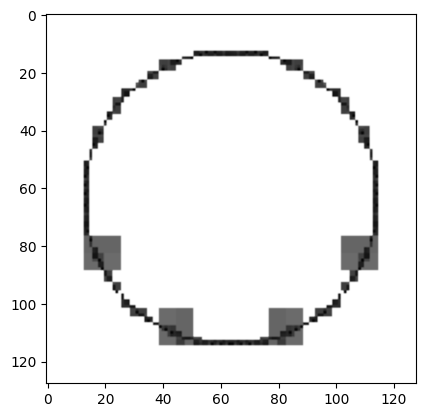

In [318]:

plt.imshow(np.log(image_res[:,:]+1e-8),cmap="Greys")

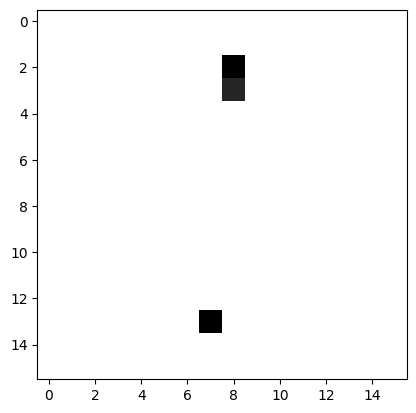

In [258]:

plt.imshow(vec_f,cmap="Greys")

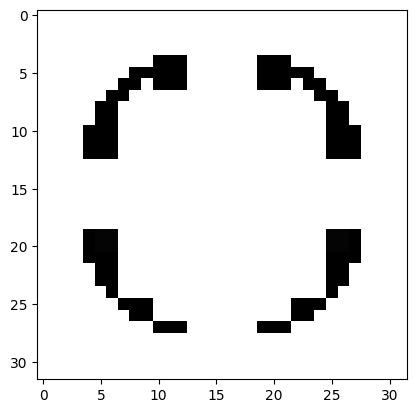

In [137]:
vec_f[vec_f>10]=10
plt.imshow(vec_f,cmap="Greys")

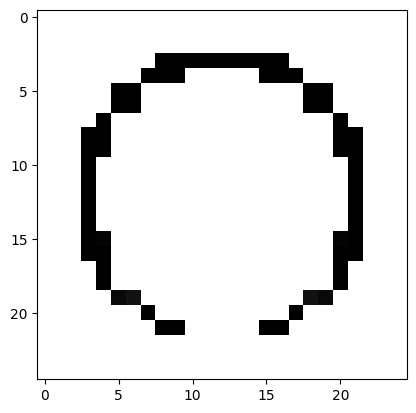

In [105]:
vec_f[vec_f>10]=10
plt.imshow(vec_f,cmap="Greys")

In [ ]:
for i in range(n_p):
    print(i)
    for j in range(n_p):
        
        coor=torch.zeros(2)
        coor[0]=vec[i]
        coor[1]=vec[j]
        
        tmp_res=0
        
                    
                    
        image_res[i][j]=tmp_res